# Overview
Here we attempt to calibrate the image processing code based on the image coming in.
## The reason
How can we be certain that a given image data is part of the same paticle? Given that each subsection represents a different z axis, we could be looking at two different particles in the same rough x and y, that happen to be in the same z, or it could be a "shadow" from the same particle. Here are reasoining is this: if a given particle is within a certain radius of the brightest particle detected, then we can be reasonale sure that it is the same paticle
## The catch ( calibration )
However, depending on where the particle is located, it's "shadows" will have a different offset from the given particle. ( See pdf on calibration for more details ) , In a nutshell, if the particle is in -5.0 z corrdinates, then the offset for -5.1, won't be much, and -5.2 more of an offset and -5.3 even more still. In other words, the further from the Z corrdinate, the bigger, and different, offset.
## Summary, belows code incorporates the calibration and takes the test data to plot and visualize the trajectory of the scanned paticle in 3 dimensions.

In [1]:
# Importing libraires and defining model for fitting
import os
import ccd_helpers
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from skimage import morphology as morph
import lmfit
import math
from lmfit.models import GaussianModel
from lmfit.lineshapes import gaussian
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
from PIL import Image, ImageOps
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion

## Search for peaks within radius

In [2]:
def psearch_grid(peaks, x_grid, y_grid, radius):
    
    """
        Takes the z_grid (blurred or otherwise) of image data and returns a copy of z_grid with 
        only the peaks detected within the radius. If we are looking at image data with multiple 
        particles on it, alter the if statement at the bottom to remove the values. This should be 
        able to return a grid with only peaks that are part of the same particle
        
    Args:    
        peaks[numpy 2D array]: z_grid data of image
        x_grid[numpy 2D array]: 2D grid of the range of x values (-1 ~ 1)
        y_grid[numpy 2D array]: 2D grid of the range of y values (-1 ~ 1)
        radius[float]: The radius to search
        
    Returns:
        numpy 2D array with only the peak values detected ( a clone of z_grid ) and
        everything else removed (a value of 0)
    """
    
    
    # First get them as a list for other functions
    peaks_list = ccd_helpers.get_2D_list(peaks, x_grid, y_grid)
    
    # Find the strongest value in the list
    StrongX, StrongY = ccd_helpers.find_strongest_dude(peaks_list)
    
    # Get the correct Calibrations
    Calibp = [ccd_helpers.find_segment(StrongX, StrongY), StrongX, StrongY]
     
    # Define brightest_seg for calibrations, so we know which offsets to use
    brightest_seg = Calibp[0]
    
    # An empty grid of zeros to put the peaks we found
    keep = np.zeros(np.shape(peaks))
    
    # Loop over every peak
    for i in range(len(peaks)):
        for j in range(len(peaks)):
            
            # Find the segment we are currently in
            segment = ccd_helpers.find_segment(x_grid[i][j], y_grid[i][j])
            # If we are within the defined range of the ccd
            if segment != None:
            
                #Get the offsets
                offsetX = Calib[brightest_seg]["Segment:"+str(segment)][0]
                offsetY = Calib[brightest_seg]["Segment:"+str(segment)][1]
    

                # Get the relative points(used to calculate offsets)
                rel_x, rel_y = ccd_helpers.get_relative_pos(brightest_seg, segment)
            
                
                # Apply the strongest x and y positions
                rel_x = rel_x + StrongX + offsetX
                rel_y = rel_y + StrongY + offsetY
                

                # The distance between the current particle and the relative distance
                # based on the offets
                dist = math.dist([rel_x, rel_y],[x_grid[i][j], y_grid[i][j]])
                
                # If within our search zone, keep the peak
                if dist < radius:
                    keep[i][j] = peaks[i][j]
                    # if needed can remove the detected peaks in case of multiple
                    # particles
                    # peaks[i][j] = 0
                    
     # Return our detected peaks           
    return keep        

# Particle Trajectory

In [3]:
def get_particle_traj(folder_name):
    """ Gets the x, y and z particle trajectories from csv files and appends them to the
        Lists provded. 

    Args:
        folder_name[string]: The name of the folder to extract data files from.
        xtraj[List / array]: An empty list to append the x traj values to.
        ytraj[List / array]: An empty list to append the y traj values to.
        ztraj[List / array]: An empty list to append the z traj values to.

    Returns:
        Returns three arrays with the x, y and z values of the particles trajectory

    """
    # Arrays to store the particles
    xtraj = []
    ytraj = []
    ztraj = []
    
    
    # Defining Depth and sections of photo
    depth = [-6.25, -6.15,-6.05,-5.95,-5.85,-5.75]
    
    selection = [ [-0.837, -0.279, -0.558, 0.000],
                  [-0.279, 0.279, -0.558, 0.000],
                  [0.279, 0.837, -0.558, 0.000],
                  [0.279, 0.837, 0.000, 0.558],
                  [-0.279, 0.279, 0.000, 0.558],
                  [-0.837, -0.279, 0.000, 0.558] ]

    # first get folder with all files to go through
    imgs = ccd_helpers.get_img_files(folder_name)

    # the length of that file will be the outer loop
    img_loop = len(imgs)
    
    
    # Parameters
    sigma = 2 # For gaussian blur
    connectivity = 2 # for detect peaks connectivity

    # Loop through the length of the img files
    for i in range(img_loop):

        # select the image file name string
        img = imgs[i]
        
        # build the file path using the folder name and img file name
        filepath = folder_name + "/" + img
        
        # Open the image file and convert it to a np array of floats
        img_data = Image.open(filepath)
        z_grid = np.array(img_data).astype('float')
        
        # Apply Gaussian filter
        z_grid = gaussian_filter(z_grid, sigma)

        
        # Get the dimensions of the image; used to create the x and y values
        dimensions = z_grid.shape 

        # With the length of the second dimension, create - 1 ~ 1 with dimensions[1] value 
        x = np.linspace(-1, 1, dimensions[1])

        # With the length of the first dimension, create - 1 ~ 1 with dimensions[0] value
        y = np.linspace(1, -1, dimensions[0])
        
        # Make a grid of the xand 1 data
        x_grid, y_grid = np.meshgrid(x, y) 

         # Applying threshold
        threshold = np.max(z_grid) * 0.1
        z_grid[z_grid<threshold] = 0
        
        # Detected particles within radius
        keep_grid = psearch_grid(z_grid, x_grid, y_grid, 0.05)
        
        #keep_grid = psearch_grid(z_grid, x_grid, y_grid, 0.25)
        
        
        # Plotting for reference
        fig = plt.figure(figsize=(16, 10))
        # setting values to rows and column variables
        rows = 1 
        columns = 1
        
        fig.add_subplot(rows, columns, 1) 
        # showing image
        plt.title("Detected Kept")
        plt.imshow(keep_grid)
        

        # For each of the 6 sections in each cv
        coefs = [] 
        coefs_a = []
        coefs_cx = []
        coefs_cy = []

        # iterate over windows
        for j in range(6):
            # Define window
            xmin = selection[j][0]
            xmax = selection[j][1]
            ymin = selection[j][2]
            ymax = selection[j][3]

            # Define offsets
            xctr = (xmin + xmax) / 2
            yctr = (ymin + ymax) / 2

            # Define subsections
            mask_x = np.logical_and(x_grid >= xmin, x_grid <= xmax)
            mask_y = np.logical_and(y_grid >= ymin, y_grid <= ymax)
            mask = np.logical_and(mask_x,mask_y)


            # Apply mask to subsections
            X = x_grid[mask] 
            Y = y_grid[mask]
            Z = keep_grid[mask]

            # Offset the XY data
            X -= xctr
            Y -= yctr

            # Get the labels
            mask = mask.astype(int)
            z_label = morph.label(mask, connectivity=2) # mask - ndarray of dtype int
            

            # Apply the gaussian 2D fit
            ccd_helpers.gaussian2D_fit(z_label, X, Y, Z, coefs, plot=False)

            #append a, cx and cy values to arrays
            coefs_a.append(coefs[j][0][0])
            coefs_cx.append(coefs[j][0][3])
            coefs_cy.append(coefs[j][0][4])


        # Gaussian fit 1D -> zparticle and append to array
        zparticle = ccd_helpers.gaussian1D_fit(depth, coefs_a)
        ztraj.append(zparticle)       

        # Interp for xparticle, yparticle
        x_int = np.interp(zparticle, depth, coefs_cx)
        y_int = np.interp(zparticle, depth, coefs_cy)

        # Save the points
        xtraj.append(x_int)
        ytraj.append(y_int)
        
    return xtraj, ytraj, ztraj
            

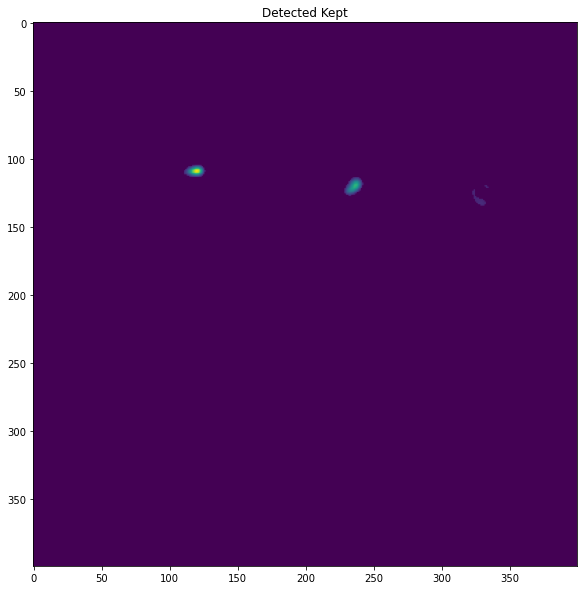

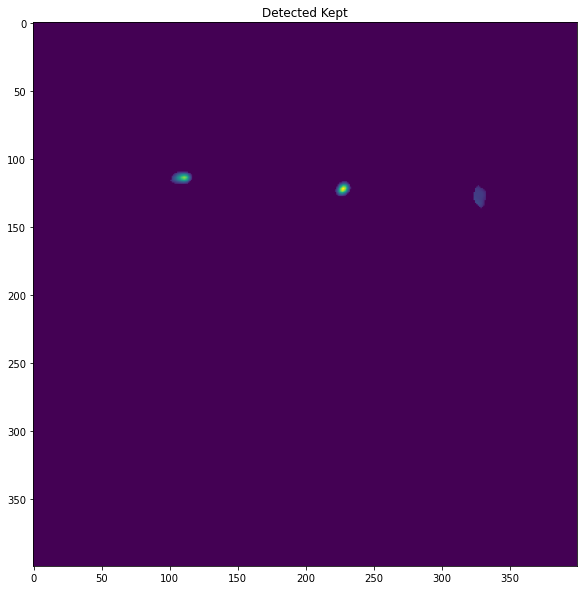

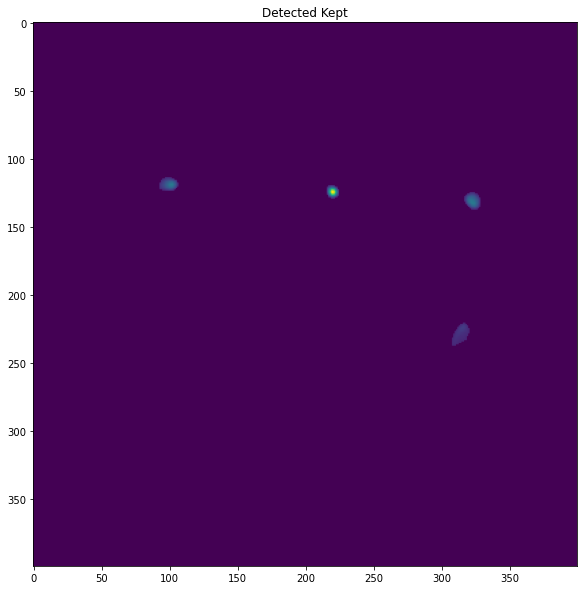

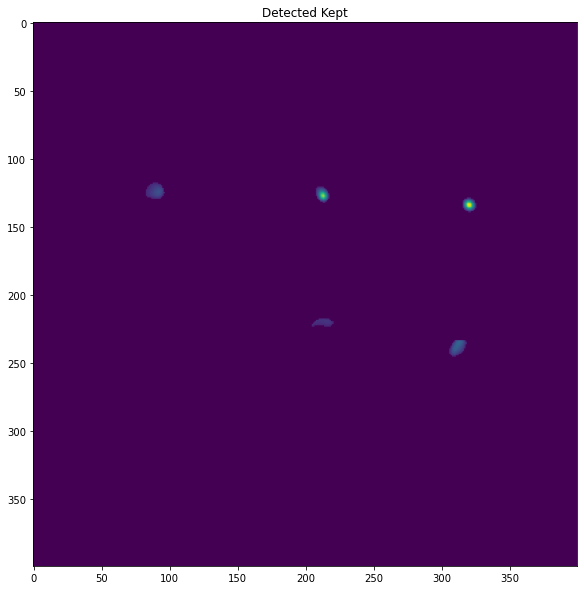

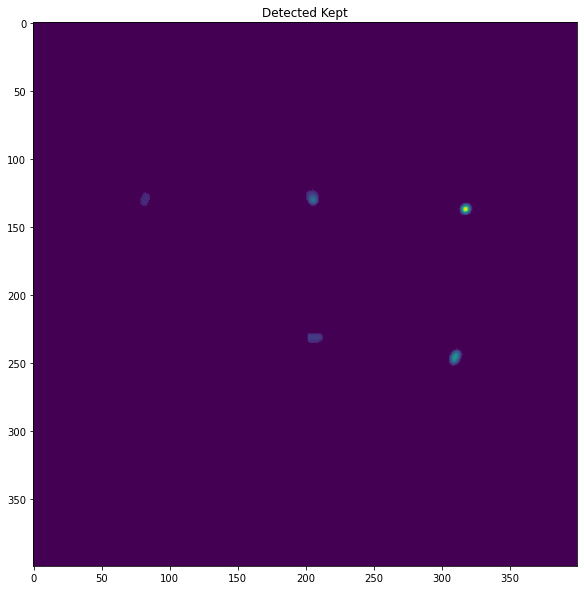

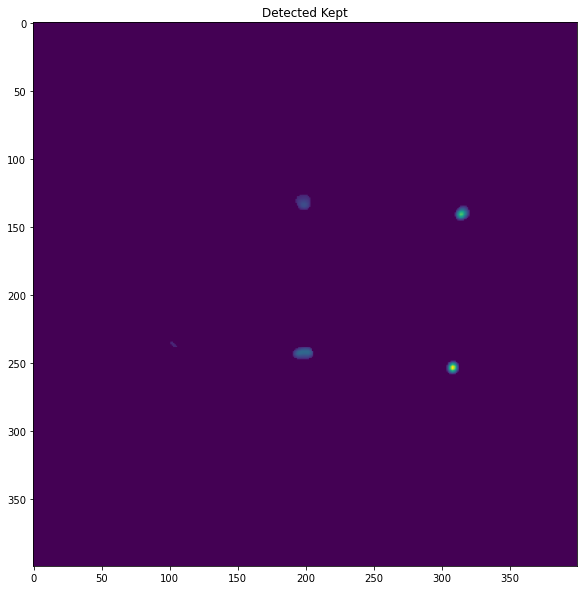

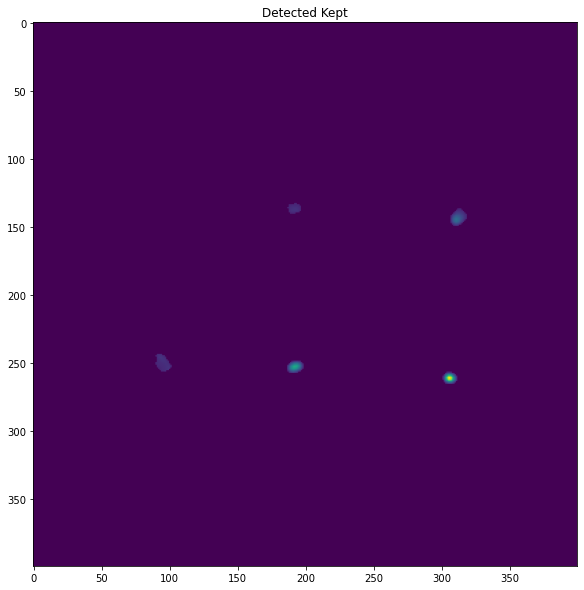

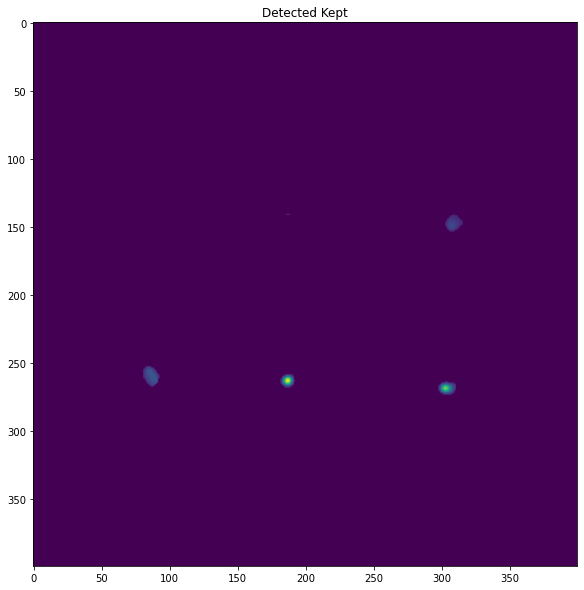

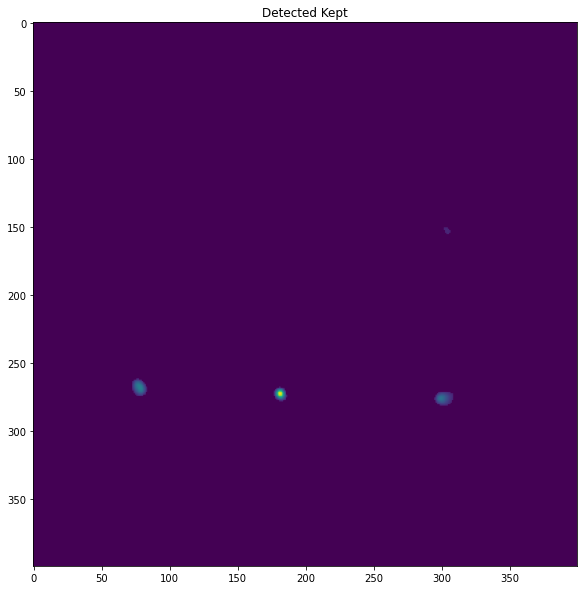

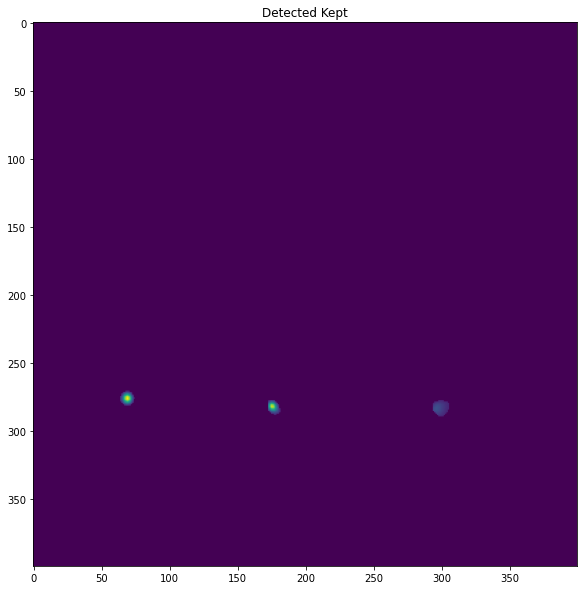

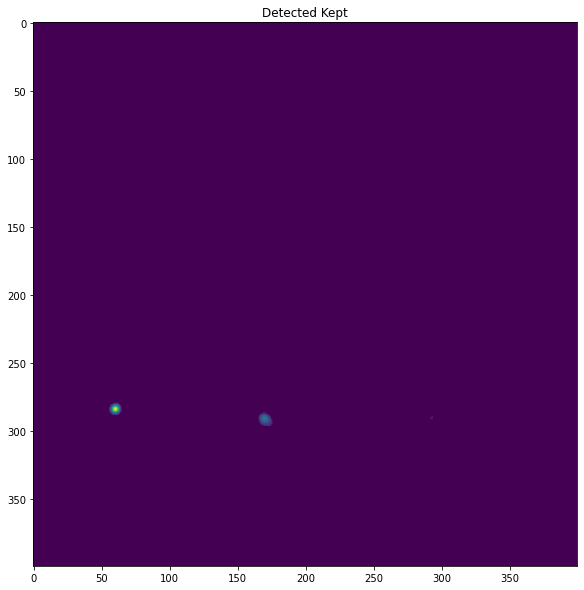

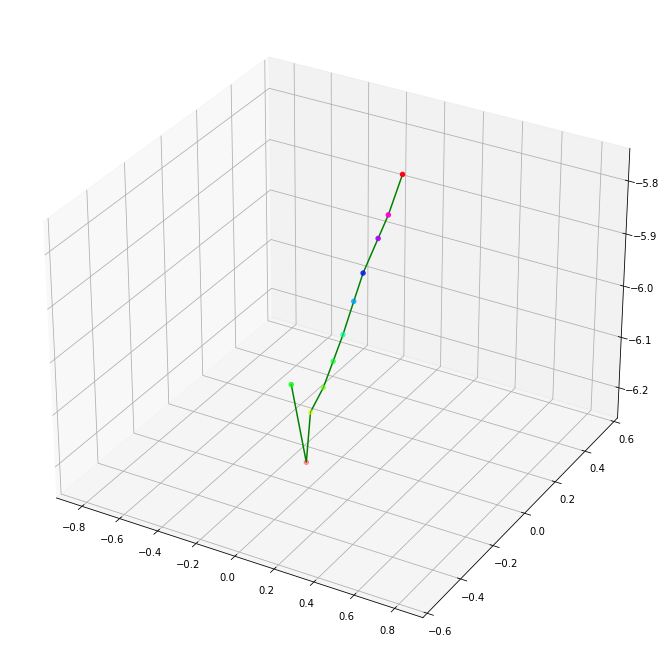

In [4]:
# Define the calibrations to use for offsets
Calib = ccd_helpers.get_Calibs('Calibrations')

#Save the x, y and z values of the particles in the specified folder
xtraj, ytraj, ztraj = get_particle_traj("ScanXYZ_Cal")

# Graph the results
ccd_helpers.line_sctr_3D(xtraj, ytraj, ztraj)